In [1]:
import lib ## my module set

import os
import torch
import torchvision
import pandas as pd 
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import random

import seaborn as sns


from tqdm import tqdm
from IPython.display import display
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pytorch_metric_learning import losses
from pytorch_metric_learning import miners
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0, mobilenet_v2, shufflenet_v2_x1_5
from sklearn.metrics import silhouette_score, silhouette_samples


%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


plt.rcParams['font.family'] = 'Liberation Serif'

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)  # 멀티 GPU를 사용하는 경우
np.random.seed(42)
random.seed(42)
# torch.backends.cudnn.deterministic = True ## 속도가 느려질 수 있음
# torch.backends.cudnn.benchmark = False

In [2]:
train = pd.read_csv("./train_v2.csv")
valid = pd.read_csv("./valid_v2.csv")
test = pd.read_csv("./test_v2.csv")

In [3]:
train_dataset = lib.CustomDataset(train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

valid_dataset = lib.CustomDataset(valid, train_test= False)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = True, pin_memory= True, num_workers = 8) 

test_dataset = lib.CustomDataset(test, train_test = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory= True, num_workers = 8)

In [ ]:
aug_sample, sample_label = next(iter(train_loader))
image = aug_sample[0].permute(1, 2, 0).numpy()
plt.figure(figsize=(2, 2))
plt.imshow(image)

In [ ]:
# denormalized_img = lib.denormalize(aug_sample[9])
# plt.imshow(denormalized_img.permute(1, 2, 0))

In [ ]:
#mobi = mobilenet_v2(weights = 'IMAGENET1K_V1')

In [17]:
Mobilenet = mobilenet_v2(weights = 'IMAGENET1K_V1')


In [18]:
Mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [19]:
Mobilenet = mobilenet_v2(weights = 'IMAGENET1K_V1')
Mobilenet = lib.freeze_layers_by_percentage(Mobilenet, 0.6)

Mobilenet.classifier = nn.Sequential(
    # nn.AdaptiveAvgPool2d(1),
    # nn.Flatten(),
    nn.Dropout(p=0.2, inplace = False),
    nn.Linear(1280, 256, bias = True),
    )

Mobilenet = Mobilenet.to(device)

Features 블록 총 19개 중 11개 고정
고정할 블록들: ['features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10']
고정됨: features.0.0.weight
고정됨: features.0.1.weight
고정됨: features.0.1.bias
고정됨: features.1.conv.0.0.weight
고정됨: features.1.conv.0.1.weight
고정됨: features.1.conv.0.1.bias
고정됨: features.1.conv.1.weight
고정됨: features.1.conv.2.weight
고정됨: features.1.conv.2.bias
고정됨: features.2.conv.0.0.weight
고정됨: features.2.conv.0.1.weight
고정됨: features.2.conv.0.1.bias
고정됨: features.2.conv.1.0.weight
고정됨: features.2.conv.1.1.weight
고정됨: features.2.conv.1.1.bias
고정됨: features.2.conv.2.weight
고정됨: features.2.conv.3.weight
고정됨: features.2.conv.3.bias
고정됨: features.3.conv.0.0.weight
고정됨: features.3.conv.0.1.weight
고정됨: features.3.conv.0.1.bias
고정됨: features.3.conv.1.0.weight
고정됨: features.3.conv.1.1.weight
고정됨: features.3.conv.1.1.bias
고정됨: features.3.conv.2.weight
고정됨: features.3.conv.3.weight
고정됨: features.3.conv.3.bias
고

In [ ]:
# Shufflenet = shufflenet_v2_x1_5(weights = 'IMAGENET1K_V1')
# for name, param in Shufflenet.named_parameters():
#     total_count += 1
#     for block in ['stage4', 'conv5','fc']:
#         if name.startswith(block):
#             param.requires_grad = True
#             break
#         else:
#             param.requires_grad = False
#     print(f'{name} grad {param.requires_grad}')
# print(total_count)
# print(frozen_count)


In [ ]:

## 학습을 위한 최적화, 함수, Miner 설정

loss_fn = losses.GeneralizedLiftedStructureLoss(neg_margin=1, pos_margin=0)
optimizer = torch.optim.AdamW(Mobilenet.parameters(), lr=1e-4)
miner_func = miners.MultiSimilarityMiner(epsilon=0.01)

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0




f = open("./Mobilenet.txt",'w')
f.close()

for epoch in range(Epochs):
    with open("./Mobilenet.txt", "a") as f:
        train_loss = lib.metric_train(train_loader, Mobilenet, loss_fn, optimizer, miner_func,)
        valid_loss = lib.metric_validation(valid_loader, Mobilenet, loss_fn, miner_func)
        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Valid Loss = {valid_loss:.4f}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Mobilenet.state_dict(),
                    'optimizer' : optimizer.state_dict()}, '../model_weight/Deep_metric/Mobilenet_freeze.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break



## Deep Metric Model Load 및 시각화

In [5]:
Mobilenet = mobilenet_v2(weights = 'IMAGENET1K_V1')
Mobilenet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace = False),
    nn.Linear(1280, 256, bias = True),)

checkpoint = torch.load('../model_weight/Deep_metric/Mobilenet_well?.pth')

Mobilenet.load_state_dict(checkpoint['model'])
Mobilenet = Mobilenet.to(device)


In [6]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)


## 2-stage Classifier 학습

In [8]:
## 2-stage Classifier Training

class MyNeural(nn.Module):
    def __init__(self, model):
        super(MyNeural, self).__init__()

        self.mother = model

        for param in self.mother.parameters():
            param.requires_grad = False    
        
        self.classifier = nn.Sequential(
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = False),
            nn.Linear(256, 64, bias = True),
            nn.SiLU(inplace = True),
            nn.Dropout(0.2, inplace = False),
            nn.Linear(64, 4, bias = True)
        )

    def forward(self, x):
        embedding = self.mother(x)
         
        x = self.classifier(embedding)

        return embedding, x



In [10]:
Mobilenet_with_classifier = MyNeural(Mobilenet).to(device)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(Mobilenet_with_classifier.parameters(), lr=1e-4)

save_model_name = 'Mobilenet_with_classifier_well?'

# training, Deep Metric Learning

patience = 0
Epochs = 100
best_loss = 999999.0

f = open(f"./loss_log/{save_model_name}.txt",'w')
f.close()


for epoch in range(Epochs):
    with open(f"./loss_log/{save_model_name}.txt",'a') as f:
        train_loss, train_correct = lib.classifier_train(train_loader, Mobilenet_with_classifier, loss_fn, optimizer)
        valid_loss, valid_correct = lib.classifier_validation(valid_loader, Mobilenet_with_classifier, loss_fn)

        f.write(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct} \n")
        print(f"Epoch {epoch} : Train Loss = {train_loss:.4f}, Train Correct: {train_correct} Valid Loss = {valid_loss:.4f}, Valid Correct = {valid_correct}")
        
        if best_loss > valid_loss:
            best_loss = valid_loss
            patience = 0
            print(f'Epoch {epoch} Model saved ')
            torch.save({
                    'model' : Mobilenet_with_classifier.state_dict(),
                    'optimizer' : optimizer.state_dict()}, f'../model_weight/Deep_metric/{save_model_name}.pth')
        else:
            patience += 1
            if patience == 10:
                print('early stopping')
                break
        

In [11]:
checkpoint = torch.load('../model_weight/Deep_metric/Mobilenet_with_classifier_well?.pth')

Mobilenet_with_classifier.load_state_dict(checkpoint['model'])

valid_loss, valid_correct = lib.classifier_validation(total_loader_t, Mobilenet_with_classifier, loss_fn)
print(valid_correct)

NameError: name 'loss_fn' is not defined

In [12]:
total_loader_v = DataLoader(valid_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)
total_loader_t = DataLoader(test_dataset, batch_size = 1, shuffle = False, pin_memory= True, num_workers = 8)

In [16]:
pred_acc = []
real_acc = []
embeddings = []
labels = []

with torch.no_grad():
    Mobilenet_with_classifier.eval()
    for data, label in tqdm(total_loader_v):
    
        embedding, pred = Mobilenet_with_classifier(data.to(device)) ## embeddings = (n, emb)
        embeddings.append(embedding) ## embeddings = (n, emb)
        labels.append(label.item())

        pred_acc.append(pred.argmax(1).item())
        real_acc.append(label.item())
        
embeddings = torch.stack(embeddings, dim = 1).squeeze()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 98.13it/s]


0.4618988037109375

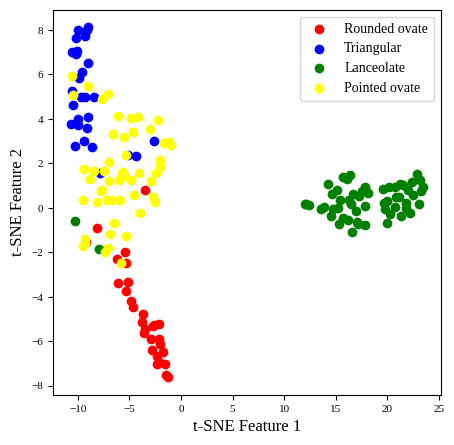

In [14]:

plt.figure(figsize=(5, 5))

plt.rc('xtick', labelsize=8)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=8)  # y축 눈금 폰트 크기
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10) 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(embeddings.detach().cpu())

df_tsne = pd.DataFrame(data = X_tsne)
df_tsne['label']= labels
df_tsne

plt.scatter(df_tsne[df_tsne['label'] == 0][0], df_tsne[df_tsne['label'] == 0][1], label = 'Rounded ovate',  c= 'red')
plt.scatter(df_tsne[df_tsne['label'] == 1][0], df_tsne[df_tsne['label'] == 1][1], label = 'Triangular', c= 'blue')
plt.scatter(df_tsne[df_tsne['label'] == 2][0], df_tsne[df_tsne['label'] == 2][1], label = 'Lanceolate', c= 'green')
plt.scatter(df_tsne[df_tsne['label'] == 3][0], df_tsne[df_tsne['label'] == 3][1], label = 'Pointed ovate',  c= 'yellow')

plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()

score = silhouette_score(X_tsne, labels)
score

In [15]:
score_samples = silhouette_samples(df_tsne[[0, 1]], df_tsne['label'])
df_tsne['sil_coeffi'] = score_samples
df_tsne.groupby('label')['sil_coeffi'].mean()

label
0    0.480196
1    0.386301
2    0.731474
3    0.196819
Name: sil_coeffi, dtype: float32

In [ ]:
plt.rc('xtick', labelsize=11)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=11) 

cm = confusion_matrix(real_acc, pred_acc, normalize = 'pred')
cm = pd.DataFrame(cm , columns = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'],index = ['Rounded Ovate', 'Triangular', 'Lanceolate', 'Pointed Ovate'])
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
from sklearn.metrics import f1_score
f1_weighted = f1_score(real_acc, pred_acc, average='macro')
f1_weighted